# 11-HUBO: Higher order unconstraint binary optimization

通常のイジングモデルまたはQUBOモデルに対して高次の項を導入したモデルを考えてみます。 具体的には２値のバイナリ変数(-1,1)もしくは(0,1)の$\sigma_{i}$ に対して次のようなエネルギー関数を導入してみましょう。

$$
H= c+\sum_{i} h_{i} \sigma_{i}+\sum_{i<j} J_{i j} \sigma_{i} \sigma_{j}+\sum_{i<j<k} K_{i, j, k} \sigma_{i} \sigma_{j} \sigma_{k}+\cdots,
\\
\sigma_i \in \{-1, 1\}, i=1,\ldots ,N
$$

ここで、添え字$i,j,k,\ldots$はバイナリ変数を指定するインデックスで、$1<= i,j,k <=N$の値を取ります。バイナリ変数は $\sigma_{i} \in \{-1, +1\}$とします。$c$は定数であり、0次の項に対応します。
このエネルギー関数の最小値を与える変数の組$(\sigma_{1} ,\sigma_{2} ,\ldots,\sigma_{N} )$を求める問題は、higher-order unconstrained binary optimization (HUBO)やpolynomial unconstrained binary optimization (PUBO)などど呼ばれています。以下ではHUBOで統一して呼称することにします。
この手の問題は通常のイジングモデルを自然に拡張したものとみなすことができ、例えば、量子化学の分野で現れます。


## HUBOの定義

本チュートリアルでは、簡単のため、以下のような3次の項しかない$N=3$変数の問題を考えます。

$$
H = -\sigma_1 -\sigma_1\sigma_2 -\sigma_1\sigma_2\sigma_3, \\ \sigma_i \in \{-1, +1\}
$$

In [1]:
import openjij as oj

# SASamplerメソッドのみが扱える。
sampler = oj.SASampler()

# 多項式の定義
polynomial = {(1,): -1, (1,2): -1, (1,2,3): 1}

## HUBOの直接解法

OpenJijではHUBOをQUBOに変換することなく、以下のsample_huboメソッドを用いることで
直接SAを行うことができます。

得られた解が、厳密解に一致していることが確かめられます。

In [18]:
response = sampler.sample_hubo(polynomial, vartype="SPIN", num_reads=1)
print(response)

   1  2  3 energy num_oc.
0 +1 +1 -1   -3.0       1
['SPIN', 1 rows, 1 samples, 3 variables]


なお、sample_huboメソッドは、辞書のkeyは数値以外も扱うことができます。

In [23]:
# 辞書のkeyは数値以外も扱うことができる。
# 相互作用を定義
polynomial_ = {('a',): -1, ('a','b'): -1, ('a','b','c'): 1}

#SAによるシミュレーションを行う回数
num_sa = 100 

# HUBOを作り、sample_huboメソッドに投げる。
response = sampler.sample_hubo(polynomial_, vartype="SPIN", num_reads=1)
# 最適化の結果を取得
print(response)

   a  b  c energy num_oc.
0 +1 +1 -1   -3.0       1
['SPIN', 1 rows, 1 samples, 3 variables]


 sample_huboメソッドを用いて100回実行したところ、異なる種類の解が複数回得られることがわかります。
 解の頻度について、エネルギーのヒストグラムとして可視化してみましょう。

In [30]:
#SAによるシミュレーションを行う回数
num_sa = 100 

response = sampler.sample_hubo(polynomial, vartype="SPIN", num_reads=num_sa)
energy_hubo = response.energies
energy_hubo

array([-3., -3., -3., -3., -3., -3., -3., -3., -3., -1., -3., -3., -1.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -1., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -3., -3., -3., -3., -3., -3., -3., -3.])

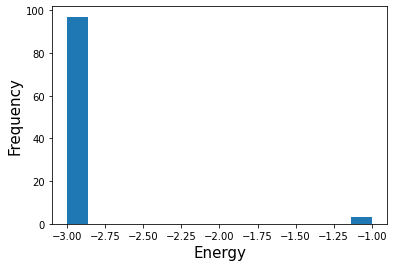

In [32]:
import matplotlib.pyplot as plt
plt.hist(energy_hubo, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが-3, -1の解が得られていることがわかります。内訳として、ほぼ-3の解が得られていることがわかります。

## QUBO変換による解法

HUBOを解く方法の一つとして、3次以上の高次の項を２次以下に変換して対応するQUBOを構成するというものがあります。QUBOに変換することで、SAやSQAなどの既存のソルバーの範囲内で解くという方針です。


3次相互作用から対応するQUBOを生成するためにD-Waveのdimodというライブラリを使います。
ここで、5.0に指定されているペナルティの大きさ(strength)は、高次相互作用を２次以下に変換する際に生じた制約条件に対するペナルティで、小さすぎると生成したQUBOの最適解がもとのHUBOと一致しなくなります。逆に大きすぎるとそもそも最適解が得られなくなってしまいます。実際上、どれくらいの値を指定すればいいのかというのは難しい問題ですが、ここでは5.0に指定しています。


In [24]:
import dimod

# Polynomial相互作用、ペナルティの大きさ、変数のタイプを指定して対応するquadraticモデルを生成する。
bqm = dimod.make_quadratic(poly=polynomial, strength=5.0, vartype="SPIN")
print('0次の項:', bqm.offset)
print('1次の項:', dict(bqm.linear))    # bqm.linearはpythonのdictに変換して表示する。
print('2次の項:', dict(bqm.quadratic)) # bqm.quadraticもpythonのdictに変換して表示する。

0次の項: 10.0
1次の項: {1: -3.5, '1*2': -3.5, 3: 0.0, 2: -2.5, 'aux1,2': -5.0}
2次の項: {('1*2', 1): 2.5, (3, '1*2'): 1.0, (2, 1): 2.5, (2, '1*2'): 2.5, ('aux1,2', 1): 5.0, ('aux1,2', '1*2'): 5.0, ('aux1,2', 2): 5.0}


見ての通りですが、もとの変数 $\sigma_1,\sigma_2,\sigma_3,\sigma_4$ に加えて $\sigma_{"0∗1"}$ などの文字列で表現された変数が現れています。一般にHUBOをQUBOに変換すると変数の数、相互作用の数が増えてしまいます。

今回のケースではHUBOの場合の変数が3個、相互作用の数も2個でしたが、QUBOに変換することで、変数が5個、相互作用の数が7個に増えています。

このQUBOをopenJijのSAで解きたいわけですが、openJijでは数値と文字列が混在した変数は扱えないため、文字列を全て整数に変換する必要があります。

In [25]:
# インデックスを1始まりの整数に変換する関数
def relabel_variables_as_integers(dimod_bqm):
    mapping = {}
    variables = list(dimod_bqm.variables)
    count = 1
    for key in variables:
        mapping[key] = count
        count += 1
    linear    = {mapping[k]:v for k,v in dimod_bqm.linear.items()}
    quadratic = {(mapping[k[0]], mapping[k[1]]):v for k,v in dimod_bqm.quadratic.items()}
    return dimod.BinaryQuadraticModel(linear, quadratic, dimod_bqm.offset, dimod_bqm.vartype), mapping


bqm_relabeled, mapping = relabel_variables_as_integers(bqm) # インデックスを1始まりに変換する。

print('0次の項:', bqm_relabeled.offset)
print('1次の項:', dict(bqm_relabeled.linear))    # bqm.linearはpythonのdictに変換して表示する。
print('2次の項:', dict(bqm_relabeled.quadratic)) # bqm.quadraticもpythonのdictに変換して表示する。
print('変数の対応関係:', mapping) # Relabelした後のインデックスと元のインデックスの対応関係を表示する。

0次の項: 10.0
1次の項: {2: -3.5, 1: -3.5, 3: 0.0, 4: -2.5, 5: -5.0}
2次の項: {(1, 2): 2.5, (3, 2): 1.0, (4, 2): 2.5, (4, 1): 2.5, (5, 2): 5.0, (5, 1): 5.0, (5, 4): 5.0}
変数の対応関係: {1: 1, '1*2': 2, 3: 3, 2: 4, 'aux1,2': 5}


それではこのQUBOをOpenJijを利用して解いてみましょう。

In [37]:
# dimodのbqm_relabeledはOpenJijのBinaryQuadraticModelに変換する。
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_relabeled.linear), dict(bqm_relabeled.quadratic), bqm_relabeled.offset, vartype="SPIN")

#　ここまでの前処理をした後に、sampleメソッドに投げることができる。
response = sampler.sample(bqm_oj, num_reads=1)
print(response) 

   1  2  3  4  5 energy num_oc.
0 +1 -1 +1 -1 +1   -1.0       1
['SPIN', 1 rows, 1 samples, 5 variables]


これを元のHUBOの解に焼き直すには対応する変数だけを見れば良いです。今回はもともと $\sigma_1,\sigma_2,\sigma_3$ という3変数でしたので、インデックスが1,2,3に対応するスピンだけを見ればいいことになります。変数を整数値に変換した際の対応関係は変換前→変換後という順番でmappingに格納されているのでこれを利用して、以下の対応するHUBOの解を得られることがわかります。

SAの性質上常に最適解が得られるわけではないことに注意してください。この解から元のHUBOのエネルギーを計算します。今得られたQUBOのエネルギーがHUBOの対応するエネルギーとは限らないことに注意してください。先に指定したペナルティの大きさstrengthの値が適切でない場合は、意味のないエネルギーが得られてしまいます。

In [28]:
# 元のHUBOの解に焼き直す。
hubo_configuration = {i: response.record[0][0][mapping[i]] for i in list(bqm_oj.variables)[:3]}
print('対応するHUBOの解:', hubo_configuration)
print('対応するHUBOの解のエネルギー:', dimod.BinaryPolynomial(polynomial, "SPIN").energy(hubo_configuration))

対応するHUBOの解: {1: 1, 2: -1, 3: 1}
対応するHUBOの解のエネルギー: -1.0


QUBO変換による解法を100回実行し、解を確認してみます。
なお、QUBO変換による解法ではエネルギーの保証がないため、元のHUBOのエネルギーを得られたバイナリー配位から直接計算します。

In [ ]:
# dimodのbqm_relabeledはOpenJijのBinaryQuadraticModelに変換する。
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_relabeled.linear), dict(bqm_relabeled.quadratic), bqm_relabeled.offset, vartype="SPIN")

#　ここまでの前処理をした後に、sampleメソッドに投げることができる。
response = sampler.sample(bqm_oj, num_reads=num_sa)

In [35]:
# 元のHUBOの解に焼き直す。
## QUBOを変換を通した解法によるエネルギー
import numpy as np

energy_quad = np.zeros(num_sa)
for i in range(num_sa):
    hubo_configuration = {j: response.record[i][0][mapping[j]] for j in list(bqm_oj.variables)[:3]}
    energy_quad[i] = dimod.BinaryPolynomial(polynomial, "BINARY").energy(hubo_configuration)

energy_quad

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -3., -1., -3.,
       -1., -3., -1., -3., -1., -1.,  3.,  3., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.,  3., -1., -1., -3., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -3., -1., -1., -1., -1.,
       -1., -1., -3., -1., -1., -1., -1., -1., -1.,  3., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

 QUBO変換による解法を100回実行したところ、異なる種類の解が複数回得られることがわかります。
 解の頻度について、エネルギーのヒストグラムとして可視化してみましょう。

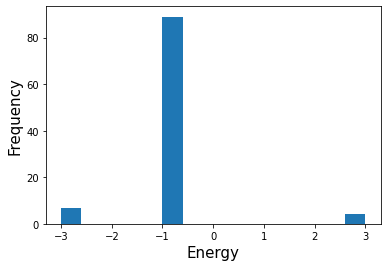

In [38]:
plt.hist(energy_quad, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが-3, -1, 3の解が得られていることがわかります。内訳として、ほぼ-1の解が得られていることがわかります。

ここで得られた解が元の問題に対する最適解かどうかを調べるために、dimodのExactPolySolverを使って確認します。

## 元のHUBOの最適解の確認とHUBOによる直接解法とQUBO変換による解法結果の比較

In [29]:
# 元のHUBOの最適解を確認する。
sampleset = dimod.ExactPolySolver().sample_hising(h = {}, J = polynomial)
print('最適解:',sampleset.first.sample)
print('対応するエネルギー:',sampleset.first.energy)

最適解: {1: 1, 2: 1, 3: -1}
対応するエネルギー: -3.0


元のHUBOに対する厳密解のエネルギーは-3.0であることがわかります。

最後に, HUBOによる直接解法とQUBO変換による解法を比較します。
SAによるシミュレーションを100回行い、各シミュレーションで得られたエネルギーを比較してみます。
結果をヒストグラムにすると次のようになります。

Text(0, 0.5, 'Frequency')

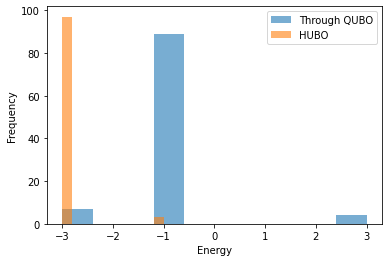

In [39]:
plt.hist(energy_quad, label='Through QUBO', alpha=0.6)
plt.hist(energy_hubo, label='HUBO', alpha=0.6)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

HUBOを直接解いた方が、良いエネルギーが得られていることがわかリます。

## QUBO変換による解法の問題点
以上より、QUBO変換による解法の問題点として、以下の2点が考えられる。

1. ペナルティの大きさ(strength)の適切な値が不明瞭
2. QUBO変換した際に変数、相互作用の数が増えてしまい、変換時間もかかってしまう